In [1]:
%load_ext autoreload
%autoreload 

In [2]:

import os 
import shutil
import numpy as n
from datetime import date
from matplotlib import pyplot as plt
import time

os.chdir('/home/ali/packages/s2p-lbm/')
from scipy import stats
import suite2p
from suite3d import plot_utils as plot

In [3]:
from importlib import reload
from pathlib import Path

In [4]:
# raw_data_path_server = '\\zortex.cortexlab.net\Subjects\SS003\2024-08-06\subset_tifs'

# save_path =  Path('/mnt/md0/runs/s2p-SS003_2024-08-06_1-2-3-4-server/')

# ops = suite2p.default_ops()
# ops['look_one_level_down'] = True
# ops['subfolders'] = []
# ops['nplanes'] = 7
# ops['fs'] = 4.12
# ops['batch_size'] = 400
# ops['threshold_scaling'] = 0.1
# ops['tau'] = 1.3
# ops['nonrigid'] = False
# ops['ignore_flyback'] = [0,1,2,3,4]
# ops['data_path'] = [raw_data_path]
# ops['save_path0'] = str(save_path)
# # print(ops)
# ops['do_registration'] = 2

In [5]:
# %%time
# output_ops = suite2p.run_s2p(ops=ops)

In [6]:
raw_data_path = '/mnt/md0/runs/s2p-SS003_2024-08-06_1-2-3-4/raw'

save_path =  Path('/mnt/md0/runs/s2p-SS003_2024-08-06_1-2-3-4/')

ops = suite2p.default_ops()
ops['look_one_level_down'] = True
ops['subfolders'] = []
ops['nplanes'] = 7
ops['fs'] = 4.12
ops['batch_size'] = 400
ops['threshold_scaling'] = 0.1
ops['tau'] = 1.3
ops['nonrigid'] = False
ops['ignore_flyback'] = []
ops['data_path'] = [raw_data_path]
ops['save_path0'] = str(save_path)
# print(ops)
ops['do_registration'] = 2

In [7]:
# %%time
# output_ops = suite2p.run_s2p(ops=ops)

In [8]:
all_ops = []
all_stats = []
Fs = []
spks = []
iscell = []
for plane in n.arange(ops['nplanes']):
    planedir = (save_path / 'suite2p' / f'plane{plane}')
    statx = planedir / 'stat.npy'
    opx = planedir / 'ops.npy'
    Fsx = planedir / 'F.npy'
    spksx = planedir / 'spks.npy'
    iscellx = planedir / 'iscell.npy'
    
    all_stats.append(n.load(statx, allow_pickle=True))
    all_ops.append(n.load(opx, allow_pickle=True).item())
    Fs.append(n.load(Fsx))
    spks.append(n.load(spksx))
    iscell.append(n.load(iscellx))

iscell = n.concatenate(iscell).astype(bool)

mean_img = n.stack([op['meanImg'] for op in all_ops])

ref_img = n.stack([op['refImg'] for op in all_ops])


# corr_map = n.stack([op['Vcorr'] for op in all_ops])

nz = mean_img.shape[0]

In [9]:
Fs = n.concatenate(Fs)[iscell[:,0]]
spks = n.concatenate(spks)[iscell[:,0]]

In [10]:
imgdir = Path('/mnt/md0/runs/pub-figs/')

In [11]:
# gifdir = imgdir / 'lbm-largefov-s2p-refimg-gif'
# os.makedirs(gifdir, exist_ok=True)
# for i in range(nz):
#     f,ax,__ = plot.show_img(ref_img[i])
#     depth = (-nz+i + 1)*20
#     ax.text(0.05, 0.05, f'$\Delta z$:{depth:04d}um', transform = ax.transAxes, fontdict={'color':'white', 'family':'monospace'})
#     plt.savefig(gifdir / f'lbm-largefov-ss003-20240806-s2p-refimg-plane{i+1:02d}.png', bbox_inches = 'tight')

In [12]:
xshifts = []
yshifts = []
for op in all_ops:
    xshifts.append(op['xoff'])
    yshifts.append(op['yoff'])
xshifts = n.array(xshifts)
yshifts = n.array(yshifts)

metrics_dir ='/mnt/md0/runs/s3d-SS003_2024-08-06_1-2-3-4subset/registered_fused_data'
metric_files = []
reg3d_files = []
for file in os.listdir(metrics_dir):
    if 'metrics' in file:
        metric_files.append(file)
    if 'offsets' in file:
        reg3d_files.append(file)
metric_files = n.sort(metric_files)
reg3d_files = n.sort(reg3d_files)
all_metrics = {}
for file in metric_files:
    metric = n.load(os.path.join(metrics_dir,file), allow_pickle=True).item()
    for k in metric.keys():
        if k not in all_metrics:
            all_metrics[k] = []
        all_metrics[k].append(metric[k])
        
for k in all_metrics.keys():
    all_metrics[k] = n.stack(all_metrics[k])
    # all_metrics.append(metric)


reg3d = {}
for file in reg3d_files:
    reg3df = n.load(os.path.join(metrics_dir,file), allow_pickle=True).item()
    for k in reg3df.keys():
        if k not in reg3d:
            reg3d[k] = []
        reg3d[k].append(reg3df[k])
        
for k in reg3d.keys():
    reg3d[k] = n.concatenate(reg3d[k])
    # all_metrics.append(metric)

In [16]:
xshifts.shape

(7, 2000)

In [19]:
reg3d['sub_pixel_shifts'].shape

(2000, 3)

In [62]:
xshift_zmean = xshifts - xshifts.mean(axis=1, keepdims=True)

# difference between plane x and the mean of all planes other than x at each time
devs = n.abs(n.array([xshift_zmean[idx] -  xshift_zmean[n.where(n.arange(xshift_zmean.shape[0]) != idx)[0]].mean(axis=0) \
                                  for idx in range(xshift_zmean.shape[0])]))


In [81]:

colors = ["#90be6d", "#e98a15", "#b26c98", "#1b9aaa", "#3a405a"]

In [91]:
import tifffile

from suite2p import registration
tifdir = Path('/mnt/md0/runs/s2p-SS003_2024-08-06_1-2-3-4/raw')
tif_names = n.sort(os.listdir(tifdir))
tif_idx = 7
toffset = 700
plane_idx = 6
mov = tifffile.imread(tifdir / tif_names[tif_idx])

tif_names = n.sort(os.listdir(tifdir))

ccs_list = [[] for i in range(nz)]

for tif_idx in range(len(tif_names[:20])):
    mov3d = tifffile.imread(tifdir / tif_names[tif_idx])
    print(f"Running tif {tif_idx:03d}")
    for plane_idx in range(mov3d.shape[1]):
        ops = all_ops[plane_idx]
        ref_img = ops['refImg']
        
        ref_masks = registration.register.compute_reference_masks(ref_img, ops)
        
        maskMul, maskOffset, cfRefImg, maskMulNR, maskOffsetNR, cfRefImgNR, blocks = ref_masks 
        
        rmin, rmax = ops['rmin'], ops['rmax']
        
        fsmooth = mov3d[:,plane_idx].copy()
        # rigid registration
        data=n.clip(fsmooth, rmin, rmax) if rmin > -n.inf else fsmooth
        maskMul=maskMul
        maskOffset=maskOffset
        cfRefImg=cfRefImg
        maxregshift=ops["maxregshift"]
        smooth_sigma_time=ops["smooth_sigma_time"]

        min_dim = n.minimum(*data.shape[1:])  # maximum registration shift allowed
        lcorr = int(n.minimum(n.round(maxregshift * min_dim), min_dim // 2))
        
        #cc = convolve(data, cfRefImg, lcorr)
        data = registration.register.rigid.convolve(data, cfRefImg)
        cc = n.real(
            n.block([[data[:, -lcorr:, -lcorr:], data[:, -lcorr:, :lcorr + 1]],
                      [data[:, :lcorr + 1, -lcorr:], data[:, :lcorr + 1, :lcorr + 1]]]))

        ccs_list[plane_idx].append(cc)

nccx, nccy = cc.shape[1:]

ccs = n.array(ccs_list)
ccs = ccs.reshape(nz, -1, nccx, nccy)

Running tif 000
Running tif 001
Running tif 002
Running tif 003
Running tif 004
Running tif 005
Running tif 006
Running tif 007
Running tif 008
Running tif 009
Running tif 010
Running tif 011
Running tif 012
Running tif 013
Running tif 014
Running tif 015
Running tif 016
Running tif 017
Running tif 018
Running tif 019


In [132]:
cmap = plt.get_cmap('copper', lut=nz)

In [177]:
480 * ops['fs']

1977.6000000000001

In [209]:
from scipy import stats

Text(0, 0.5, 'Plane-to-Plane Variability')

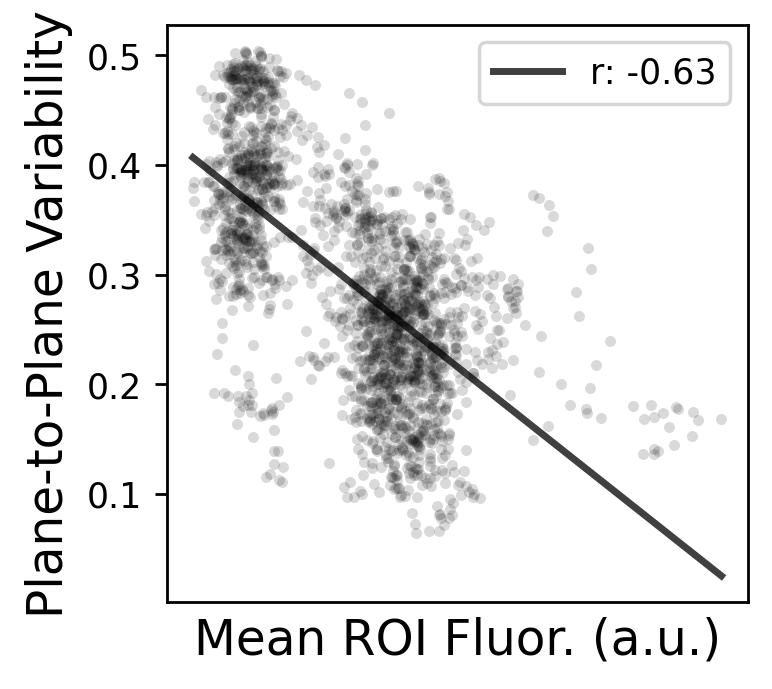

In [279]:
f,ax = plt.subplots(figsize=(3,3),dpi=250)
xs, ys = (Fs.mean(axis=0) - Fs.mean()) / Fs.mean(), plot.filt(xshifts.std(axis=0),width=5)
slopex, interceptx, rx, px, __ = stats.linregress(xs, ys)
plt.scatter(xs, ys, s = 10,alpha=0.15,lw=0, color='k')
xx = n.array([xs.min(), xs.max()])
plt.plot(xx, xx*slopex + interceptx, color='k', alpha=0.75, lw=2, label=f"r: {rx:.2f}")
ax.legend()
ax.set_xlabel("Mean ROI Fluor. (a.u.)",fontsize=14)
ax.set_xticks([])
ax.set_ylabel("Plane-to-Plane Variability",fontsize=14)

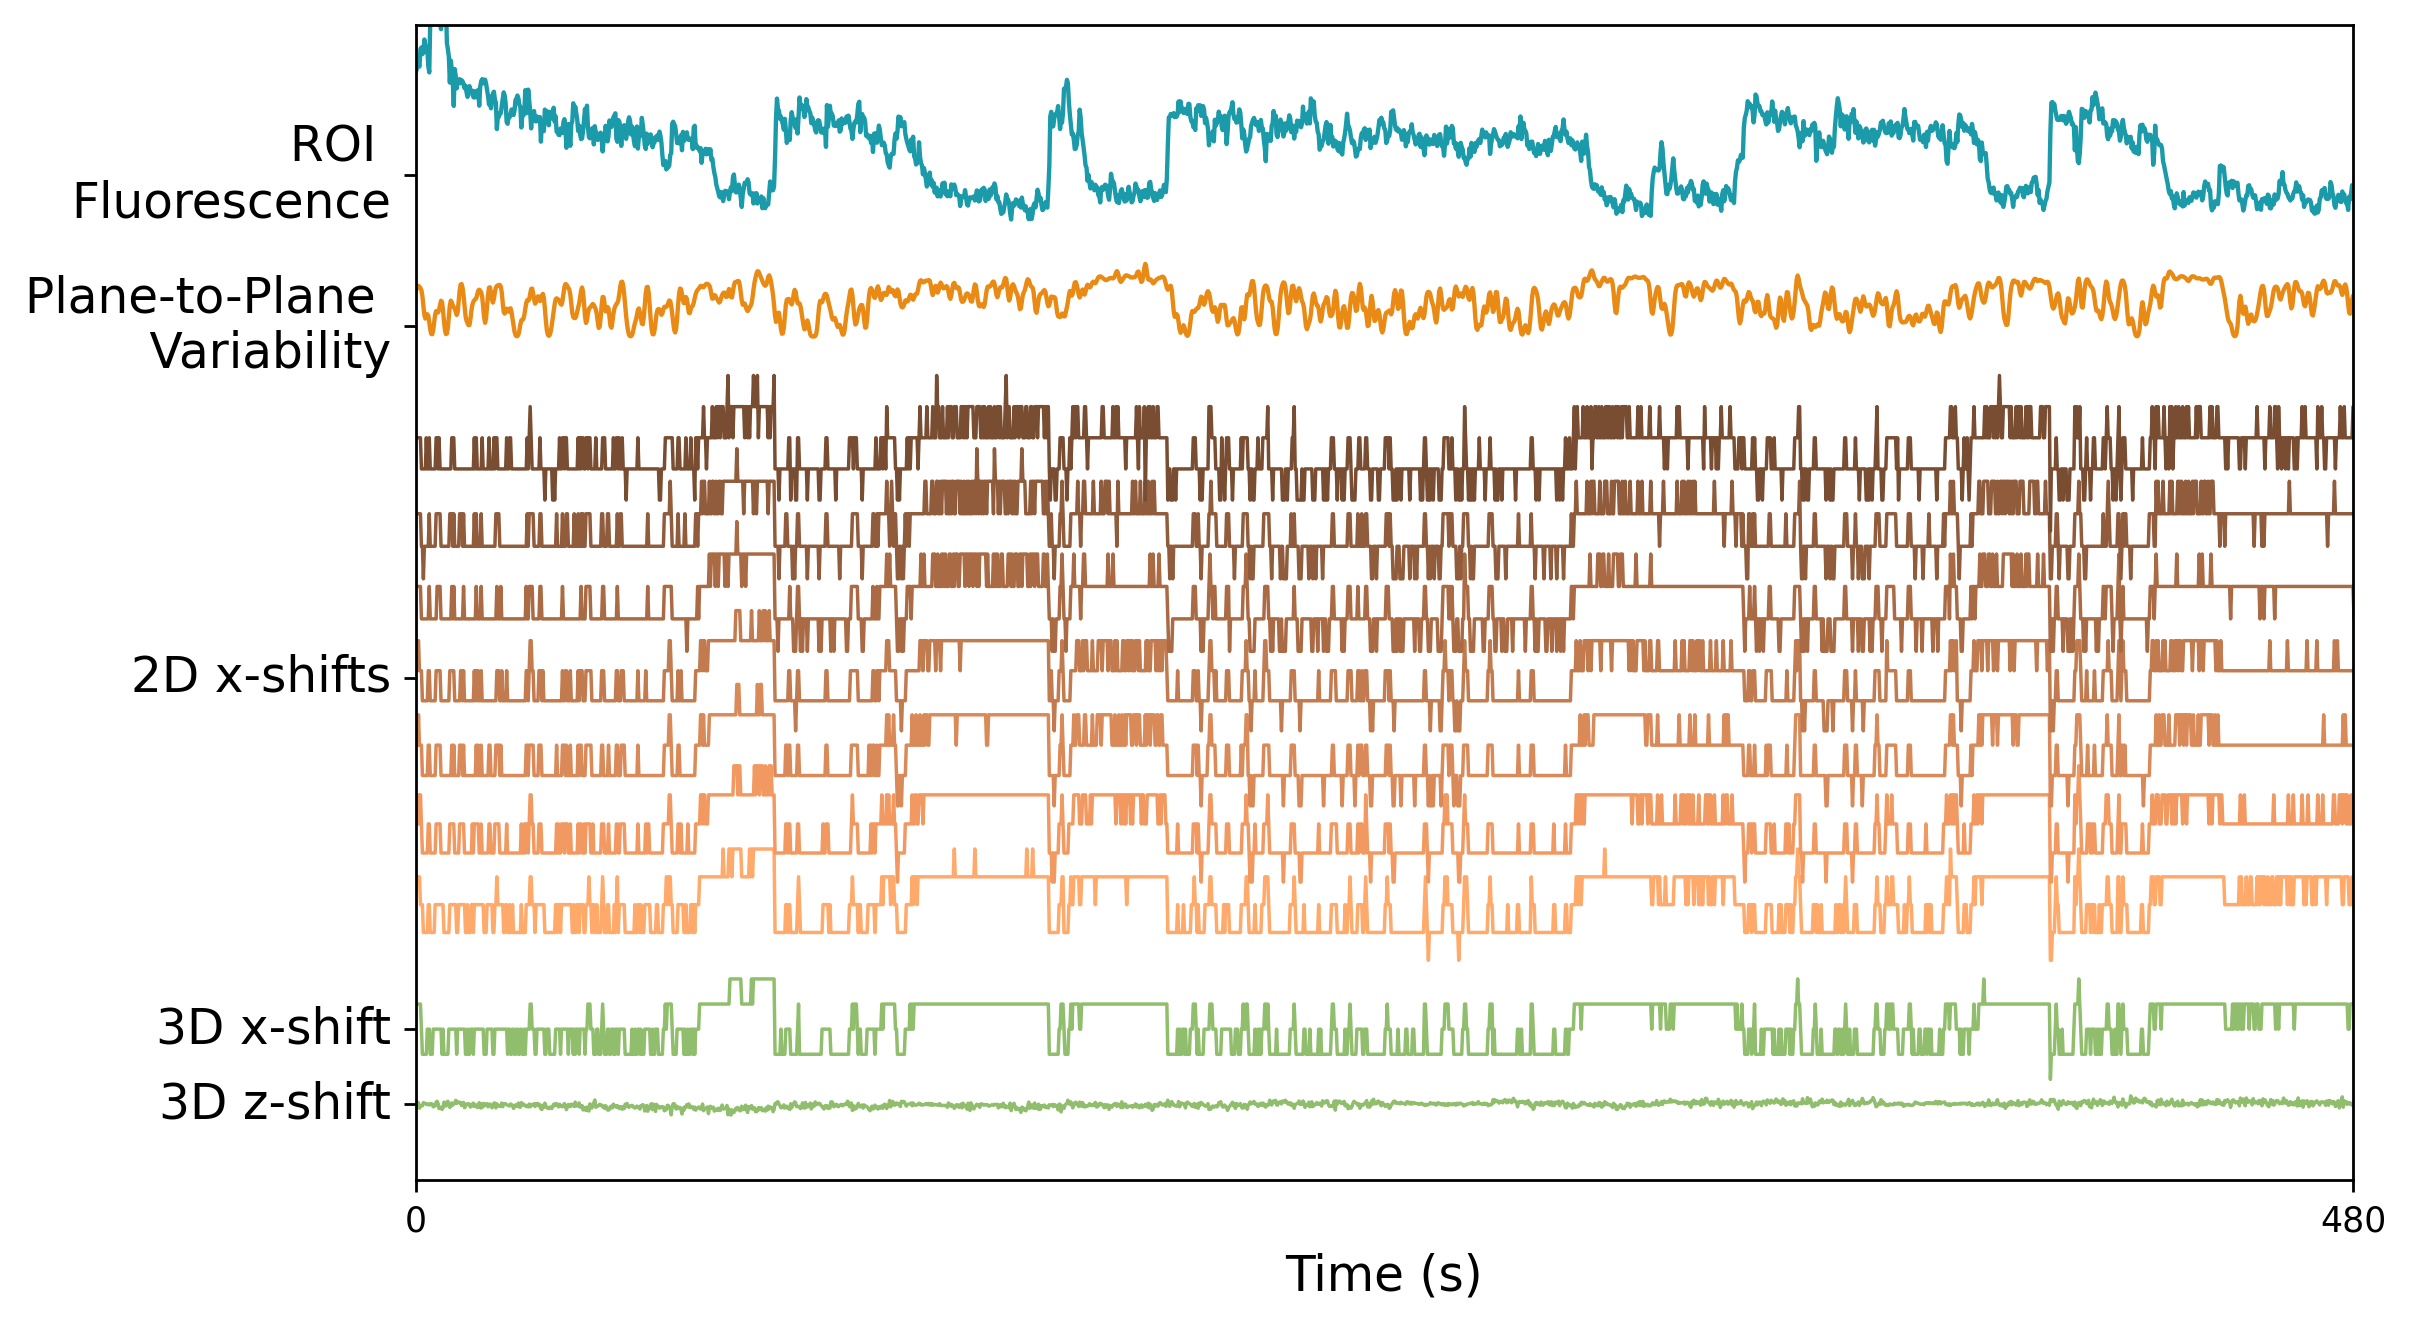

In [273]:
cmap = plt.get_cmap('copper', lut=2*nz)
colors = ["#90be6d","#e98a15","#b26c98","#1b9aaa","#3a405a"]
f,ax = plt.subplots(figsize=(10,6), dpi=250)
plot.multiple_timeseries(n.arange(xshifts.shape[1]), xshifts, colors=[cmap(2*nz-i-3) for i in range(nz)],
                         labels=[f'Plane {idx+1:01d}' for idx in range(nz)],ax=ax)
ax.set_ylabel("x-shift")
ax.set_xlabel("Frames")
# ax.plot(2*plot.filt(plot.zscore(n.median(devs,axis=0)),width=1.5)+24, lw=1, color=colors[2])
ax.plot(plot.filt(plot.zscore(xshifts.std(axis=0)),width=1.5)+24, lw=1.25, color=colors[1])
ax.plot(1.5*plot.zscore(Fs.mean(axis=0))+30, lw=1.25, color=colors[3])

ax.set_ylim(-11, 35)
ax.set_yticks([-8,-5,9, 23, 29], ['3D z-shift','3D x-shift', '2D x-shifts', 'Plane-to-Plane \n Variability', 'ROI \nFluorescence'],fontsize=14)

ax.plot(-5+reg3d['int_shift'][:,2], color=colors[0], lw=1)
ax.plot(-8+0.1*plot.zscore(reg3d['sub_pixel_shifts'][:,0]), color=colors[0], lw=1)
# ax.set_
ax.set_xlim(0,1978)
ax.set_ylabel('')
ax.set_xlabel("Time (s)",fontsize=14)
ax.set_xticks([0,1978], [0,480])

In [220]:
plidxs, tidxs = n.unravel_index(n.argsort(devs.flatten()), devs.shape)

0.22166666666666657
0.2783333333333333
0.05499999999999983
0.05499999999999983
0.05499999999999983
0.7216666666666667
0.05499999999999994
0.11166666666666669
0.44499999999999995
0.05499999999999983


[]

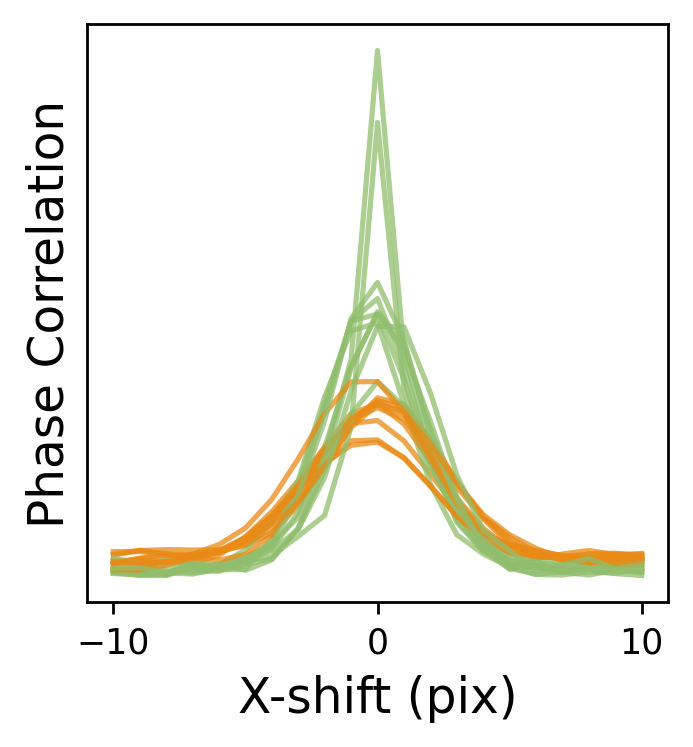

In [276]:
n_example = 10
n.random.seed(10)
tidxs = n.random.choice(ccs.shape[1], n_example, replace=False)
f,ax = plt.subplots(figsize=(3,3),dpi=250)
wsize = 10
colors = ["#90be6d","#e98a15","#b26c98","#1b9aaa","#3a405a"]
for i in range(n_example):
    plane_idx = 3
    tidx = tidxs[i]
    print(devs[plane_idx][tidx])    
    ymax, xmax = n.unravel_index(n.argmax(ccs[plane_idx][tidx]), (nccy,nccx))    
    lgood = ax.plot(n.arange(-wsize, wsize+1),ccs[plane_idx][tidx][ymax, xmax-wsize:xmax+wsize+1], color=colors[1], alpha = 0.75)


    # ccline = reg3d['phase_corr_shifted'][tidx][2][40][40-wsize:40+wsize+1] 
    
    zmax,ymax, xmax = n.unravel_index(n.argmax(reg3d['phase_corr_shifted'][tidx]), reg3d['phase_corr_shifted'][tidx].shape)

    ccline = reg3d['phase_corr_shifted'][tidx][zmax][ymax][xmax-wsize:xmax+wsize+1] 
    lgood = ax.plot(n.arange(-wsize, wsize+1),ccline,  alpha = 0.75, color=colors[0])
ax.set_ylabel("Phase Correlation",fontsize=14)
ax.set_xlabel("X-shift (pix)", fontsize=14)
ax.set_xticks([-10,0,10])
ax.set_yticks([])

In [250]:
idxs = (1,-1)

In [251]:
reload(plot)

<module 'suite3d.plot_utils' from '/home/ali/packages/s2p-lbm/suite3d/plot_utils.py'>

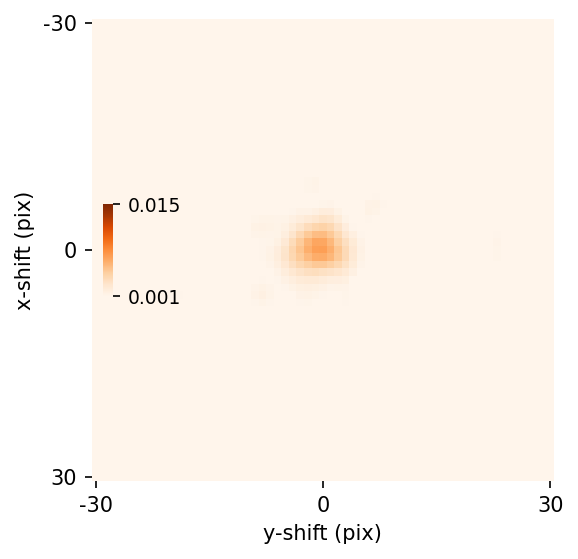

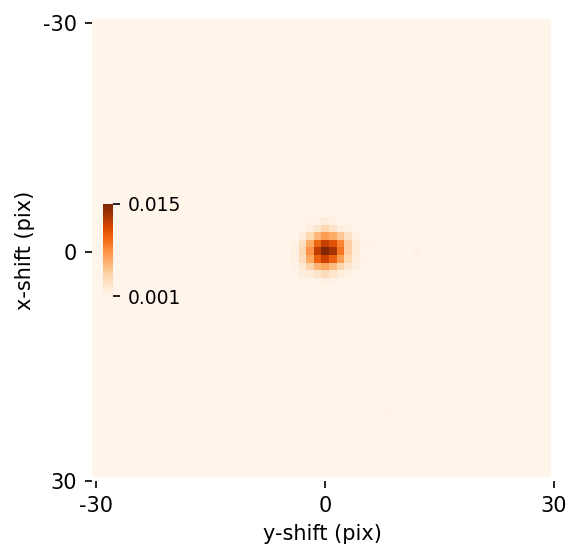

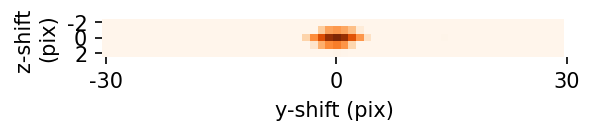

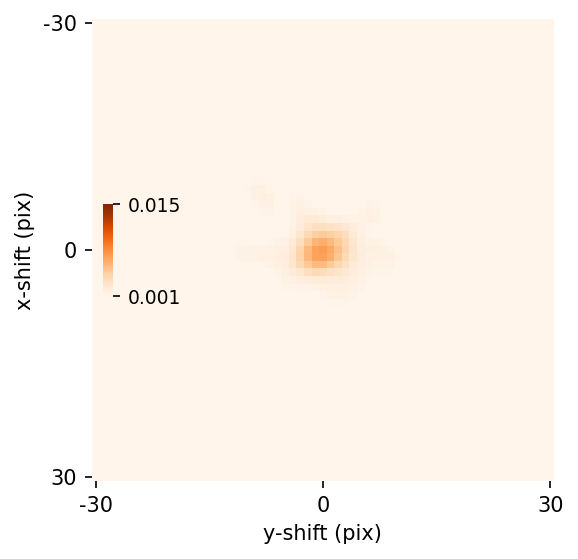

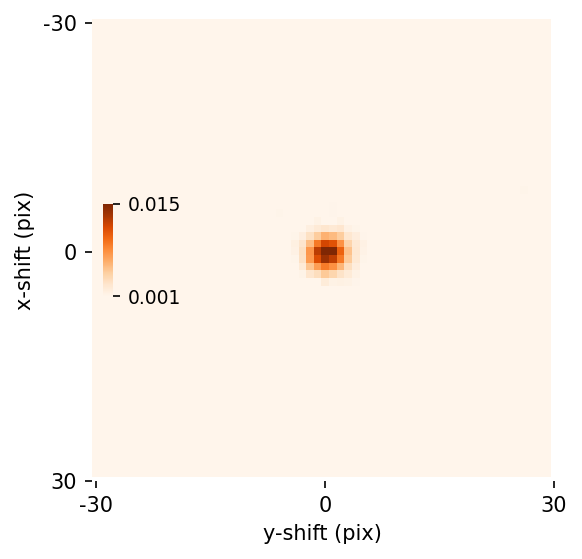

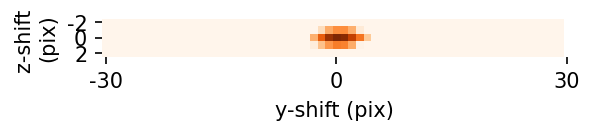

In [252]:
imsize = 30
vminmax = (0.001, 0.015)
for idx in idxs:
    plane_idx = plidxs[idx]
    tidx = tidxs[idx]
    ymax, xmax = n.unravel_index(n.argmax(ccs[plane_idx][tidx]), (nccy,nccx))
    f,ax,im = plot.show_img(ccs[plane_idx][tidx][ymax-imsize:ymax+imsize+1,xmax-imsize: xmax+imsize+1], 
                            # norm = plot.mpl.colors.LogNorm(*vminmax),
                            vminmax=vminmax, cmap='Oranges', cbar=True,figsize=(4,4), cax_label_format='%.3f') 
    ax.set_xticks([0,imsize,2*imsize])
    ax.set_xticklabels([-imsize,0,imsize])
    ax.set_yticks([0,imsize,2*imsize])
    ax.set_yticklabels([-imsize,0,imsize])
    ax.set_xlabel("y-shift (pix)")
    ax.set_ylabel("x-shift (pix)")

    
    zmax,ymax, xmax = n.unravel_index(n.argmax(reg3d['phase_corr_shifted'][tidx]), reg3d['phase_corr_shifted'][tidx].shape)

    f,ax,im = plot.show_img(reg3d['phase_corr_shifted'][tidx][zmax][ymax-imsize:ymax+imsize,xmax-imsize:xmax+imsize],
                            # norm = plot.mpl.colors.LogNorm(*vminmax),
              vminmax=vminmax,cmap='Oranges',cbar=True,figsize=(4,4), cax_label_format='%.3f')
    ax.set_xticks([0,imsize,2*imsize])
    ax.set_xticklabels([-imsize,0,imsize])
    ax.set_yticks([0,imsize,2*imsize])
    ax.set_yticklabels([-imsize,0,imsize])
    ax.set_xlabel("y-shift (pix)")
    ax.set_ylabel("x-shift (pix)")



    f,ax,im = plot.show_img(reg3d['phase_corr_shifted'][tidx][:,ymax-imsize:ymax+imsize,xmax],
                            norm = plot.mpl.colors.LogNorm(*vminmax),
                                vminmax=vminmax, cmap='Oranges', cbar=False,figsize=(4,4), cax_label_format='%.3f') 
    ax.set_xticks([0,imsize,2*imsize])
    ax.set_xticklabels([-imsize,0,imsize])
    ax.set_xlabel("y-shift (pix)")
    
    ax.set_yticks([0,zmax, reg3d['phase_corr_shifted'][tidx].shape[0]-1], [-zmax,0, reg3d['phase_corr_shifted'][tidx].shape[0] - zmax -1])
    # ax.set_xticklabels([-zmax,0, reg3d['phase_corr_shifted'][tidx].shape[0] - zmax ])
    ax.set_ylabel("z-shift \n(pix)")